In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2 as cv

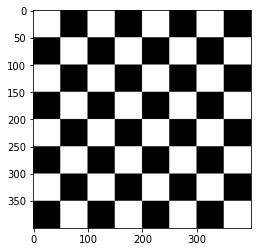

In [2]:
I = np.zeros((400, 400), np.uint8)
w = 50
for i in range(10):
    a = i+1 % 2
    for j in range(10):
        b = (j + a) % 2
        cv.rectangle(I, (i*w, (j)*w), ((i+1)*w, (j+1)*w ), b*255, -1)
        ## print(b * 255)

plt.imshow(I, cmap='gray')

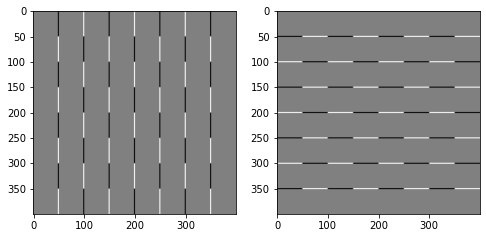

In [3]:
def compute_gradients(img, ksize=3):
    Ix = cv.Sobel(img, ddepth=cv.CV_64F, dx=1, dy=0, ksize=ksize)
    Iy = cv.Sobel(img, ddepth=cv.CV_64F, dx=0, dy=1, ksize=ksize)

    #Ix = Ix.astype(float)
    #Iy = Iy.astype(float)
    return Ix, Iy

Ix, Iy = compute_gradients(I)

fig=plt.figure(figsize=(8, 8))
fig.add_subplot(1, 2, 1)
plt.imshow(Ix, cmap='gray')
fig.add_subplot(1, 2, 2)
plt.imshow(Iy, cmap='gray')
plt.show()

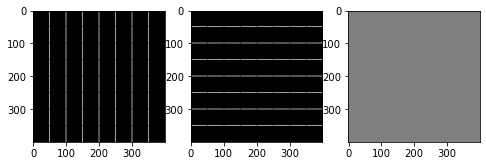

In [4]:
def compute_products(Ix, Iy):
    Ixx = np.multiply(Ix, Ix)
    Iyy = np.multiply(Iy, Iy)
    Ixy = np.multiply(Ix, Iy)
    return Ixx, Iyy, Ixy

Ixx, Iyy, Ixy = compute_products(Ix, Iy)

fig=plt.figure(figsize=(8, 8))
fig.add_subplot(1, 3, 1)
plt.imshow(Ixx, cmap='gray')
fig.add_subplot(1, 3, 2)
plt.imshow(Iyy, cmap='gray')
fig.add_subplot(1, 3, 3)
plt.imshow(Ixy, cmap='gray')
plt.show()

In [5]:
def same_area(a, b, window_size = 5):
    dx = abs(a[0]-b[0])
    dy = abs(a[1]-b[1])
    return (dx < window_size) and (dy < window_size)

# Algorithm parameters
def list_corners(img, window_size=3, tau=0.5):
    s = window_size # Linear size of a square window
    
    response = []
    w, h = img.shape

    offset = int(np.floor(s/2))
    #print(offset)
    n_image = img/255
    # print(n_image)
    Ix, Iy = compute_gradients(n_image, ksize=window_size)
    Ixx, Iyy, Ixy = compute_products(Ix, Iy)
    for x in range(w-s+1):
        # print("{} - {}".format(x,(x+s)))
        for y in range(h-s+1):
            Sxx = Ixx[x:x+s, y:y+s].sum()
            Syy = Iyy[x:x+s, y:y+s].sum()
            Sxy = Ixy[x:x+s, y:y+s].sum()
            C = np.array([[Sxx, Sxy],[Sxy, Syy]])
            lambdas, _ = np.linalg.eig(C)
            lambda2 = np.sort(lambdas)[0]
            # print(lambda2)
            if (lambda2>tau):
                response.append( {'l2': lambda2, 'coord': (x+offset,y+offset), 'suppressed': False } )

    response.sort(reverse=True, key=lambda e: e['l2'])
    
    print("Max lambda2: {}".format(response[0]['l2']))

    for i in range(len(response)):
        if not response[i]['suppressed']:
            for j in range(i+1, len(response)):
                if not response[j]['suppressed']:
                    if (same_area(response[i]['coord'], response[j]['coord'], window_size*1.2)):
                        response[j]['suppressed'] = True

    corners = list(filter(lambda e: not e['suppressed'], response))
    return corners



In [6]:
def plot_corners(img, corners):
    corner_x = []
    corner_y = []
    for corner in corners:
        corner_x.append(corner['coord'][0])
        corner_y.append(corner['coord'][1])

    fig, ax = plt.subplots(figsize=(15,15))
    color_img = cv.cvtColor(img,cv.COLOR_GRAY2RGB)
    ax.imshow(color_img)
    ax.scatter(corner_x, corner_y, s=50, c='r')

Max lambda2: 14624.0


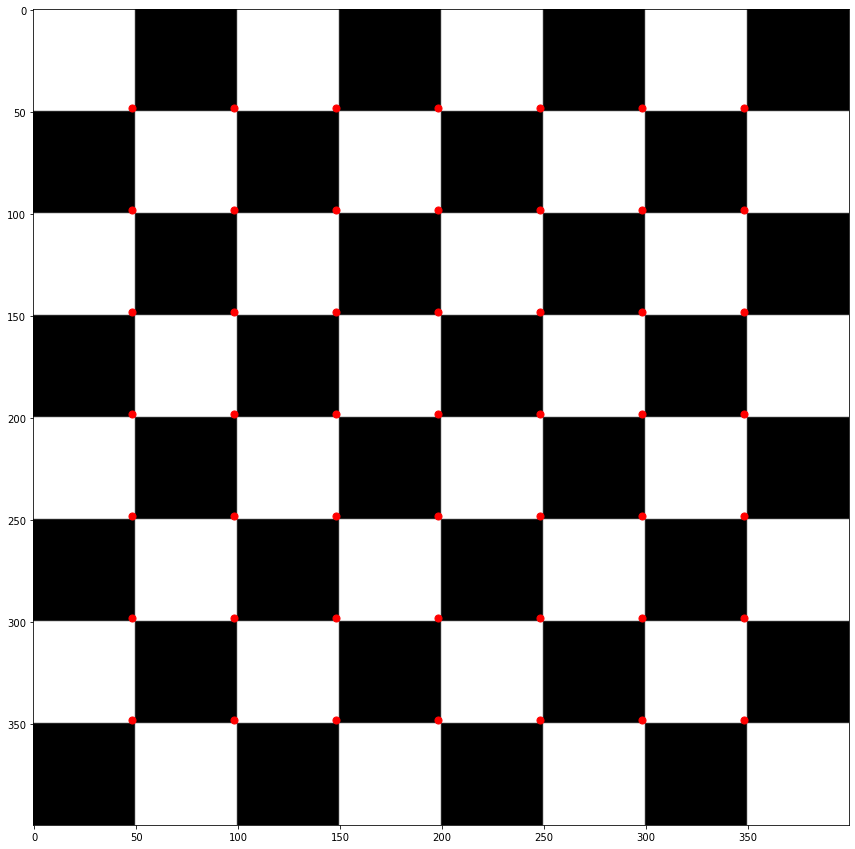

In [7]:
noise = cv.GaussianBlur(I,(1, 1),0)
corners = list_corners(noise, window_size=5, tau=0.5)   
plot_corners(noise, corners)

Max lambda2: 3035.003398692811


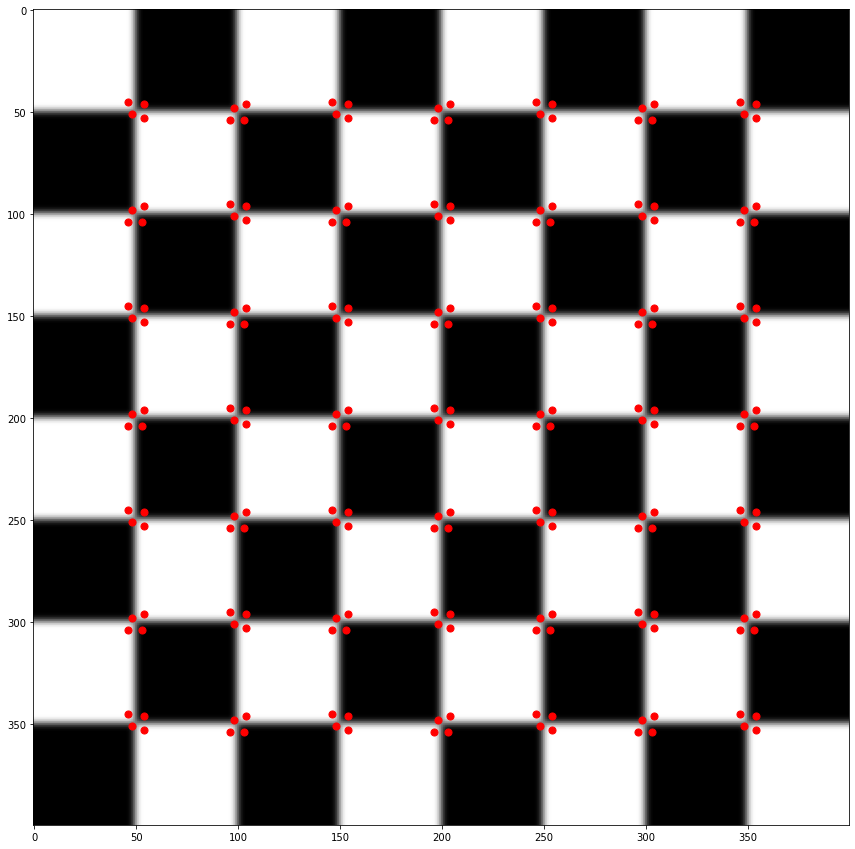

In [8]:

noise = cv.GaussianBlur(I,(9, 9),0)
corners = list_corners(noise, window_size=5, tau=0.5)   
plot_corners(noise, corners)

In [10]:
from sklearn.metrics import mean_squared_error
# The image corners are located in cordinates multiples of 50
def ideal_position(coord):
    xo = round(coord[0]/50)*50
    yo = round(coord[1]/50)*50
    return (xo, yo)

def distance_to_nearest(coord):
    xo, yo = ideal_position(coord)
    
    dx = float(xo) - float(coord[0])
    dy = float(yo) - (coord[1])
    
    return np.sqrt(np.power(dx,2) + np.power(dy,2))


def calc_kpi(corners, tolerance=5):
    missed = {}
    w = 50
    for i in range(1,8):
        for j in range(1,8):
            missed[(i*w,j*w)] = 1
    zeros = []
    errors = []
    spurious = 0
    for corner in corners:
        coord = corner['coord']
        error = distance_to_nearest(coord)
        if error < tolerance:
            zeros.append(0.0)
            errors.append(error)
            key = ideal_position(coord)
            missed[key] = 0
        else:
            spurious = spurious +1
    
    rmse = 0
    if (len(zeros)>0):
        rmse = mean_squared_error(zeros, errors)
    return rmse, spurious, sum(missed.values())
            
calc_kpi(corners, tolerance=3)    

(6.469387755102042, 147, 0)

In [11]:
gaussian_noise = [1, 3, 5, 7, 9, 11, 13, 15, 17, 21]
window_sizes = [5]
tau_values = [0.05]

#kernel_sizes = [1, 3, 5, 9]
#window_sizes = [3, 5, 7, 9, 11, 13, 15]

rmse_series = {}
fp_series = {}
fn_series = {}

values = np.zeros(())

for sigma in gaussian_noise:
    blurred = cv.GaussianBlur(I,(sigma, sigma),0)
    print('Processing image with filtered with kernel size {}'.format(sigma))
    for ws in window_sizes:
        for tau in tau_values:
            corners = list_corners(blurred, window_size = ws, tau = tau)
            rmse, false_positives, missed_corners = calc_kpi(corners, tolerance=ws)
            rmse_series[sigma] = rmse
            fp_series[sigma] = false_positives
            fn_series[sigma] = missed_corners


#plot_corners(blurred, corners_blurred)

Processing image with filtered with kernel size 1
Max lambda2: 14624.0
Processing image with filtered with kernel size 3
Max lambda2: 9525.338254517494
Processing image with filtered with kernel size 5
Max lambda2: 6836.856470588235
Processing image with filtered with kernel size 7
Max lambda2: 4247.599538638986
Processing image with filtered with kernel size 9
Max lambda2: 3035.003398692811
Processing image with filtered with kernel size 11
Max lambda2: 2005.622329873126
Processing image with filtered with kernel size 13
Max lambda2: 1479.8711264898118
Processing image with filtered with kernel size 15
Max lambda2: 987.601445597847
Processing image with filtered with kernel size 17
Max lambda2: 695.758062283737
Processing image with filtered with kernel size 21
Max lambda2: 382.0561322568244


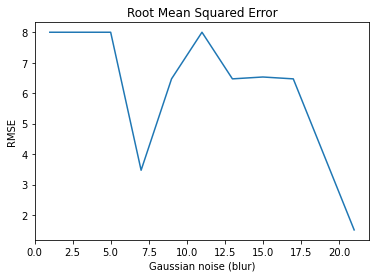

In [12]:
sigmas = []
errors = []
for s in rmse_series:
    sigmas.append(s)
    errors.append(rmse_series[s])
    
plt.title('Root Mean Squared Error')
plt.ylabel('RMSE')
plt.xlabel('Gaussian noise (blur)')

plt.plot(sigmas, errors)

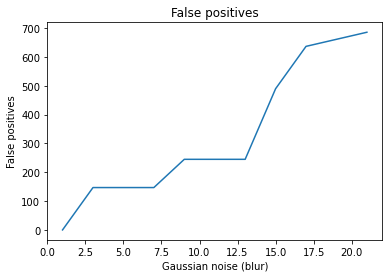

In [13]:
sigmas = []
errors = []
for s in fp_series:
    sigmas.append(s)
    errors.append(fp_series[s])
    

plt.title('False positives')
plt.ylabel('False positives')
plt.xlabel('Gaussian noise (blur)')
plt.plot(sigmas, errors)


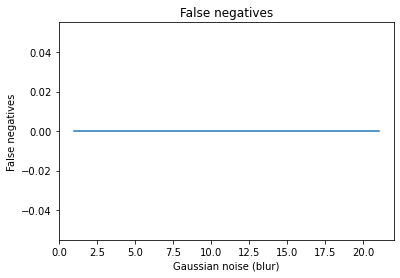

In [14]:
sigmas = []
errors = []
for s in fn_series:
    sigmas.append(s)
    errors.append(fn_series[s])
    

plt.title('False negatives')
plt.ylabel('False negatives')
plt.xlabel('Gaussian noise (blur)')
plt.plot(sigmas, errors)

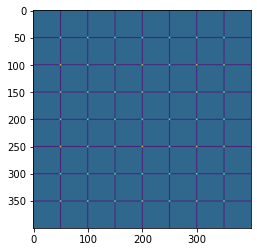

In [15]:
blockSize = 2
apertureSize = 3
k = 0.04
dst = cv.cornerHarris(I, blockSize, apertureSize, k)
plt.imshow(dst)